# Spin Wave Simulation

Instrument: ARCS
* Ei=100meV
* Fermi chopper: 600 Hz
* T0: 120Hz
 
Sample: some crystal
* lattice parameters: 2, 2.5, 3        90 90 90
* spin wave: E = 80 * | sin($\pi$k) |
* Orientation: u,v = [1 0 2] and  [1 0 0]
* psi angles: -90, 90, step 3


## Step 0. some goodies

In [44]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import histogram.hdf as hh, histogram as H

## Step 1. create dir structure

In [2]:
# Change this!!!
workdir = "/SNS/users/lj7/simulations/ARCS/spinwave-along-k-demo/"
!mkdir -p {workdir}

In [3]:
%cd {workdir}
!ls

/SNS/users/lj7/simulations/ARCS/spinwave-along-k-demo


In [4]:
!mkdir -p samples/X/sampleassembly
!mkdir -p beam
!mkdir -p scattering

In [5]:
!find .

.
./samples
./samples/X
./samples/X/sampleassembly
./beam
./scattering


## Step 2. obtain beam simulation

In [6]:
!ln -s /SNS/users/lj7/simulations/ARCS/beam/100meV beam/100meV

In [7]:
%cd beam/100meV

/SNS/users/lj7/simulations/ARCS/beam/100meV


In [45]:
# check
import histogram.hdf as hh
ie = hh.load("out/ienergy.h5")
plt.plot(ie.energy, ie.I)
plt.title("I(E)")

/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/histogram/hdf/__init__.py:55: UserWarning: filename as url is deprecated
  warnings.warn("filename as url is deprecated")


ValueError: out/ienergy.h5

## Step 3. Create sample assembly

In [9]:
%cd "{workdir}/samples/X/sampleassembly"

/SNS/users/lj7/simulations/ARCS/spinwave-along-k-demo/samples/X/sampleassembly


In [10]:
%cp -a /SNS/users/lj7/simulations/samples/spinwave/* .

In [11]:
%%file ./X.xyz
8
2 0 0    0 2.5 0  0 0 3
V 0.5 0.5 0.5
V 0 0 0.5
V 0 0.5 0
V 0.5 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0


Overwriting ./X.xyz


In [12]:
%%file ./sampleassembly.xml
<?xml version="1.0"?>

<!DOCTYPE SampleAssembly>

<SampleAssembly name="X"
   max_multiplescattering_loops_among_scatterers="1"
   max_multiplescattering_loops_interactM_path1="4"
   min_neutron_probability=".1"
 >
  
  <PowderSample name="X" type="sample">
    <Shape>
      <block width="4.6*cm" height="4.6*cm" thickness="2.3/4*cm"/>
    </Shape>
    <Phase type="crystal">
      <ChemicalFormula>X</ChemicalFormula>
      <xyzfile>X.xyz</xyzfile>
    </Phase>
  </PowderSample>
  
  <LocalGeometer registry-coordinate-system="InstrumentScientist">
    <Register name="X" position="(0,0,0)" orientation="(0, 0, 0)"/>
  </LocalGeometer>

  <Environment temperature="300*K"/>

</SampleAssembly>

Overwriting ./sampleassembly.xml


In [13]:
%%file ./X-scatterer.xml
<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">
    
    <E_Q_Kernel 
	E_Q="0" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
	/>
    
    <E_vQ_Kernel 
	E_Q="pi:=3.1415926535897932; twopi:=2*pi; a:=2; b:=2.5; c:=3; 
    h:=a*Qx/twopi; k:=b*Qy/twopi; l:=c*Qz/twopi; 
    cospih2:=cos(h*pi)^2; cospil2:=cos(l*pi)^2; cospik2:=cos(k*pi)^2; 
    (80.0^2*(1-cospik2)) ^ (0.5)"
	S_Q="1"
	Emax="81*meV"
	/>
    
  </KernelContainer>
  
</homogeneous_scatterer>

Overwriting ./X-scatterer.xml


In [14]:
a,b,c=2,2.5,3

from numpy import sin, cos, deg2rad
a1 = [a, 0, 0]
a2 = [0, b, 0]
a3 = [0, 0, c]

twopi = 2*np.pi
f = twopi/np.dot(a1, np.cross(a2, a3))
b1 = np.cross(a2,a3) * f
b2 = np.cross(a3,a1) * f
b3 = np.cross(a1,a2) * f
b1,b2,b3

(array([ 3.14159265,  0.        ,  0.        ]),
 array([ 0.        ,  2.51327412,  0.        ]),
 array([ 0.       ,  0.       ,  2.0943951]))

#### Orientation of the kernel
Here we need to use the convention that z is along beam, y vertical up.
The kernel has its own cartesian axis e’x e’y e’z. Because we know
u = 102 v = 100
, we have the basis vectors of the instrument coordinate system

    ez along b1 + 2*b3
    ex along b1
    

So we have them in the reciprocal cartesian axis

In [15]:
ez = b1 + 2*b3; ez /= np.linalg.norm(ez)
ex1 = b1
ey = np.cross(ez, ex1); ey/=np.linalg.norm(ey)
ex = np.cross(ey, ez)
ex, ey, ez

(array([ 0.8,  0. , -0.6]), array([ 0.,  1.,  0.]), array([ 0.6,  0. ,  0.8]))

The rotation matrix is define as
```
    ex.ex’ ex.ey’ ex.ez’ 
R = ey.ex’ ey.ey’ ey.ez’
    ez.ex’ ez.ey’ ez.ez’
```
So

In [16]:
R = np.array([ ex, ey, ez ])
Rflat = R.copy(); Rflat.shape = -1,
R, Rflat

(array([[ 0.8,  0. , -0.6],
        [ 0. ,  1. ,  0. ],
        [ 0.6,  0. ,  0.8]]),
 array([ 0.8,  0. , -0.6,  0. ,  1. ,  0. ,  0.6,  0. ,  0.8]))

Now we add an extra kernel parameter:

In [17]:
'orientation="%s"' % (','.join(str(e) for e in Rflat),)

'orientation="0.8,0.0,-0.6,0.0,1.0,0.0,0.6,0.0,0.8"'

In [ ]:
# modify X-scatterer.xml to specify the orientation

In [18]:
%%file ./X-scatterer.xml
<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">
    
    <E_Q_Kernel 
	E_Q="0" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
	/>
    
    <E_vQ_Kernel 
	E_Q="pi:=3.1415926535897932; twopi:=2*pi; a:=2; b:=2.5; c:=3; 
    h:=a*Qx/twopi; k:=b*Qy/twopi; l:=c*Qz/twopi;
    cospih2:=cos(h*pi)^2; cospil2:=cos(l*pi)^2; cospik2:=cos(k*pi)^2; 
    (80.^2*(1-cospik2)) ^ (0.5)"
	S_Q="1"
	Emax="81*meV"
	orientation="0.8,0.0,-0.6,0.0,1.0,0.0,0.6,0.0,0.8"
	/>
    
  </KernelContainer>
  
</homogeneous_scatterer>

Overwriting ./X-scatterer.xml


In [19]:
#!cat X-scatterer.xml

In [20]:
!ls

dispersion-expression  sampleassembly.xml  X-scatterer.xml  X.xyz


## Step 4. Scattering

In [21]:
%cd "{workdir}/scattering"

/SNS/users/lj7/simulations/ARCS/spinwave-along-k-demo/scattering


In [22]:
!rsync -a ~lj7/simulations/mcvine_workflow/DGS/ARCS/single-crystal/* ./
!ls

scripts  template


In [23]:
%cd template

!ln -s ../../samples/X/sampleassembly

!ln -s ../../beam/100meV beam

%cd ..

/SNS/users/lj7/simulations/ARCS/spinwave-along-k-demo/scattering/template
/SNS/users/lj7/simulations/ARCS/spinwave-along-k-demo/scattering


In [27]:
#!ls -l ./template

In [28]:
%%file sim.yml

cluster:
  nodes: 10
instrument:
  name: arcs
scatter:
  ncount: 1e6
  multiple_scattering: off
  template: ./template


Writing sim.yml


In [29]:
!./scripts/sim.py --angle=30.0

SAMPLE_ANGLE=30.0 time ./scatter &> log.scatter
time ./create-nxs &> log.create-nxs

real	2m26.017s
user	17m27.703s
sys	4m9.064s
cp sim.nxs sim-30.0.nxs
mcvine instruments arcs nxs populate_metadata --type=Ei --beam_outdir=beam/out --nxs=sim-30.0.nxs
/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/mcvine/deployment_info.py:41: UserWarning: Neither environment variable MCVINE_DIR nor DANSE_DIR was defined. Assumed that it is /SNS/users/lj7/software/miniconda2/envs/mcvine.
  warnings.warn(msg)


In [30]:
%%file sim.yml

cluster:
  nodes: 1
instrument:
  name: arcs
scatter:
  ncount: 1e6
  multiple_scattering: off
  template: ./template


Overwriting sim.yml


In [ ]:
# a script to create a submit script submit.sh
# may need to create several scripts

In [31]:
%%file create-submit.py
import numpy as np
ostream = open('submit.sh', 'wt')
for a in np.arange(-90, 90.1, 3.):
    ostream.write('./scripts/sim.py --angle=%s &\n' % a)
    continue
ostream.close()

Writing create-submit.py


In [32]:
# run the script to create submit.sh
!python ./create-submit.py

In [33]:
# check submit script
#!cat submit.sh

In [34]:
# make sure submit.sh is executable
!chmod +x submit.sh
# and then start it script in the background

In [35]:
%%script bash --bg
./submit.sh
# this will take a while to finish.

Starting job # 0 in a separate thread.


## Step 5. Reduction

In [36]:
%cd "{workdir}/scattering"
!ls

/SNS/users/lj7/simulations/ARCS/spinwave-along-k-demo/scattering
create-submit.py  work_18.0   work_-33.0  work_48.0   work_-63.0  work_78.0
scripts		  work_-21.0  work_33.0   work_-51.0  work_63.0   work_-81.0
sim.yml		  work_21.0   work_-36.0  work_51.0   work_-66.0  work_81.0
submit.sh	  work_-24.0  work_36.0   work_-54.0  work_66.0   work_-84.0
template	  work_24.0   work_-39.0  work_54.0   work_-69.0  work_84.0
work_0.0	  work_-27.0  work_39.0   work_-57.0  work_69.0   work_-87.0
work_-12.0	  work_27.0   work_-42.0  work_57.0   work_-72.0  work_87.0
work_12.0	  work_-3.0   work_42.0   work_-6.0   work_72.0   work_-9.0
work_-15.0	  work_3.0    work_-45.0  work_6.0    work_-75.0  work_9.0
work_15.0	  work_-30.0  work_45.0   work_-60.0  work_75.0   work_-90.0
work_-18.0	  work_30.0   work_-48.0  work_60.0   work_-78.0  work_90.0


First we reduce event-mode nexus data for each angle using Mantid

In [37]:
# check if there is reduced data
!ls work_2.0/reduced*

ls: cannot access work_2.0/reduced*: No such file or directory


In [38]:
# reduce tof events to E events
# this takes about 30 minutes
!./scripts/reduce/reduceKeepingEvents_batch.py -90,90.1,3. 100 0,90,0.5 > log.reduce

In [ ]:
# create configuration file for getting a slice

In [39]:
%%file slice_0K0.yml

angles: -90,90.1,3.0
filename_pattern: work_%(angle)s/reduced_%(angle)s.nxs
lattice: 2., 2.5, 3., 90, 90, 90
orientation:
 u: 1, 0, 2
 v: 1,0,0
Eaxis:
 min: 0
 max: 90
 N: 181
Q_projections:
 U:
  proj: 0,1,0
  proj_name: 0,K,0
  min: -5
  max: 5
  N: 251
 V:
  proj: 1,0,0
  proj_name: H,0,0
  min: -5
  max: 5
  N: 1
 W:
  proj: 0,0,1
  proj_name: 0,0,L
  min: -5
  max: 5
  N: 1
output: slice_0K0.nxs


Writing slice_0K0.yml


In [40]:
# hack for now. copy the config python file to current dir
!cp /SNS/users/lj7/simulations/mcvine_workflow/DGS/ARCS/single-crystal/scripts/config.py .

In [41]:
# run script to calculate the slice
# this take ~15 minutes 
! PYTHONPATH=$PWD:$PYTHONPATH ./scripts/reduce/getaslice.py slice_0K0.yml > log.slice_0K0

In [42]:
# convert slice nexus to slice histogram for plotting
!./scripts/reduce/slice2hist.py slice_0K0.nxs slice_0K0.h5

FrameworkManager-[Notice] Welcome to Mantid 3.6.100
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid3.6.100
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 1.46 seconds


plot z in (0, 1e-05)


<IPython.core.display.Javascript object>


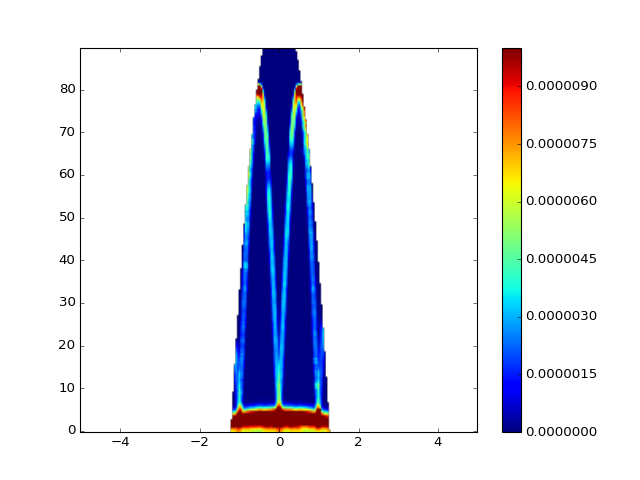

In [46]:
# plot

H.plot(hh.load("./slice_0K0.h5"), min=0, max=1e-5)

In [ ]:
# try a smaller range

In [47]:
%%file slice_0K0_-2,2.yml

angles: -90,90.1,3.0
filename_pattern: work_%(angle)s/reduced_%(angle)s.nxs
lattice: 2., 2.5, 3., 90, 90, 90
orientation:
 u: 1, 0, 2
 v: 1,0,0
Eaxis:
 min: 0
 max: 90
 N: 181
Q_projections:
 U:
  proj: 0,1,0
  proj_name: 0,K,0
  min: -2
  max: 2
  N: 401
 V:
  proj: 1,0,0
  proj_name: H,0,0
  min: -5
  max: 5
  N: 1
 W:
  proj: 0,0,1
  proj_name: 0,0,L
  min: -5
  max: 5
  N: 1
output: slice_0K0_-2__2.nxs


Writing slice_0K0_-2,2.yml


In [49]:
! PYTHONPATH=$PWD:$PYTHONPATH ./scripts/reduce/getaslice.py slice_0K0_-2,2.yml > log.slice_0K0_-2,2

In [50]:
!./scripts/reduce/slice2hist.py "slice_0K0_-2__2.nxs" slice_0K0_-2,2.h5

FrameworkManager-[Notice] Welcome to Mantid 3.6.100
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid3.6.100
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 1.22 seconds


plot z in (0, 1e-05)


<IPython.core.display.Javascript object>


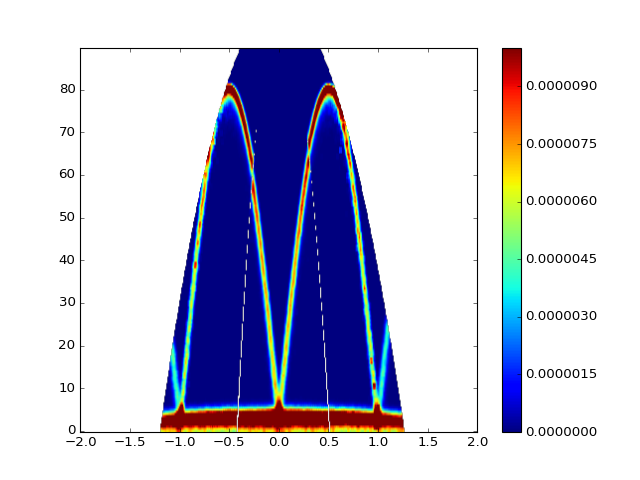

In [51]:
H.plot(hh.load("./slice_0K0_-2,2.h5"), min=0, max=1e-5)